#### Setup

In [1]:
import matplotlib.pyplot as plt

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [2]:
import numpy as np
import torch
import random
import warnings

warnings.filterwarnings("ignore")

seed_value = 42

np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
random.seed(seed_value)

# Exploratory Data Analysis
#### Loading data

In [3]:
import pandas as pd

df = pd.read_csv('..\\datasets\\bbc-cleaned.csv')
df

,category,text
0,business,ad sale boost time warner profit quarter profi...
1,business,dollar gain greenspan speech dollar hit highes...
2,business,yuko unit buyer face loan claim owner embattl ...
3,business,high fuel price hit ba profit british airway b...
4,business,pernod takeov talk lift domecq share uk drink ...
...,...,...
2220,tech,bt program beat dialler scam bt introduc two i...
2221,tech,spam e mail tempt net shopper comput user acro...
2222,tech,care code new european direct could put softwa...
2223,tech,us cyber secur chief resign man make sure us c...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df['category'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [6]:
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['length']

0        247
1        229
2        159
3        245
4        166
        ... 
2220     244
2221     216
2222     543
2223     221
2224    1466
Name: length, Length: 2225, dtype: int64

                mean: 219
       harmonic mean: 177


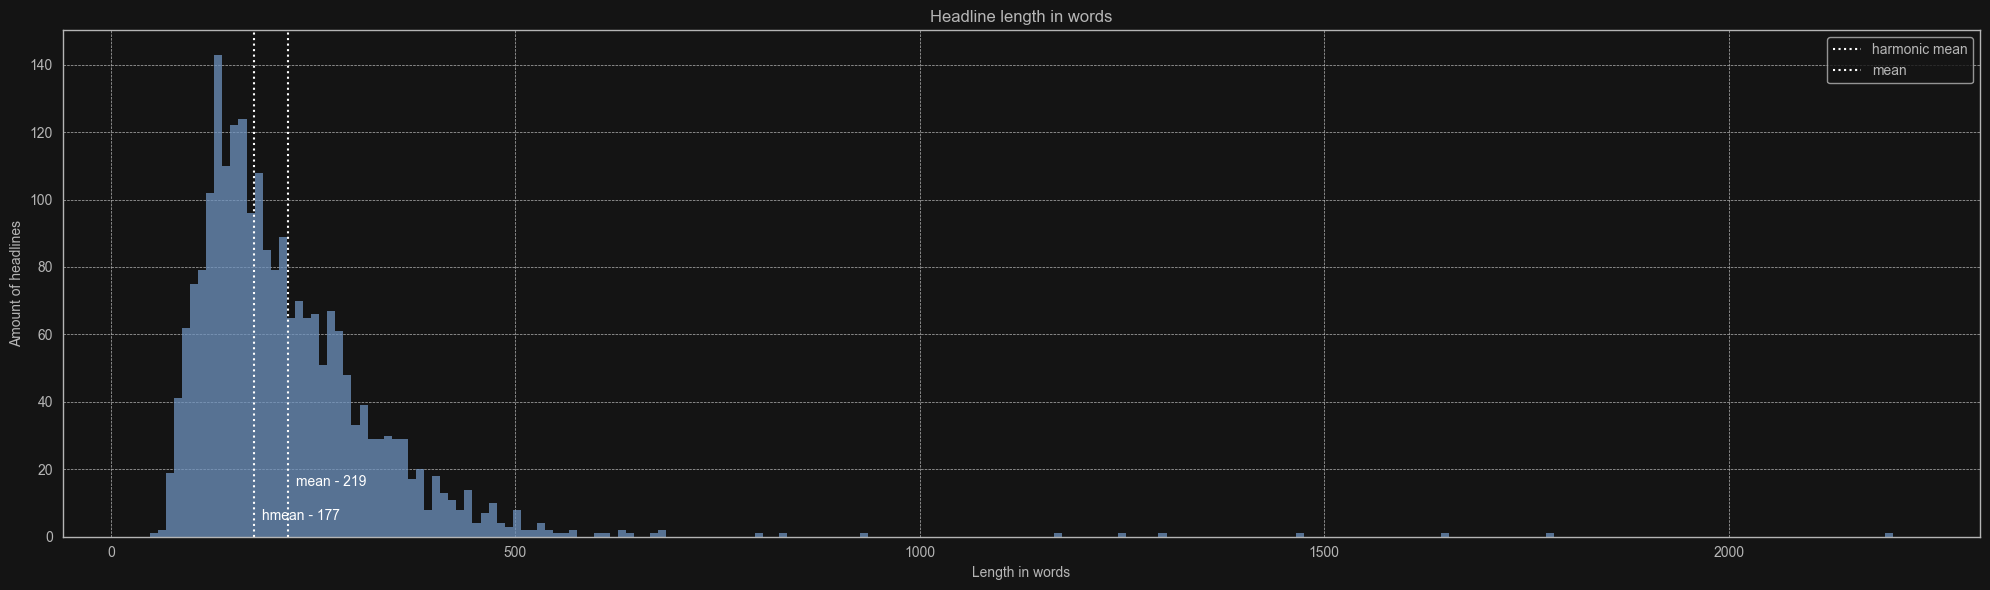

In [7]:
from scipy.stats import hmean
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

min_headline_len = df['length'].min()
max_headline_len = df['length'].max()

headline_mean = round(df['length'].mean())
headline_hmean = round(hmean(df['length']))

print(
    f"{"mean":>20}: {headline_mean}",
    f"{"harmonic mean":>20}: {headline_hmean}", sep='\n'
)

fig, axes = plt.subplots(figsize=(20, 6))

sb.histplot(df['length'], ax=axes, binwidth=10, linewidth=0, color=mid_blue)
axes.axvline(headline_hmean, linestyle=':', label='harmonic mean', color='white')
axes.axvline(headline_mean, linestyle=':', label='mean', color='white')
axes.annotate(text=f"hmean - {headline_hmean}", xy=(headline_hmean+10, 5), color='white')
axes.annotate(text=f"mean - {headline_mean}", xy=(headline_mean+10, 15), color='white')

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
axes.legend()

plt.tight_layout()

min: 386
max: 511


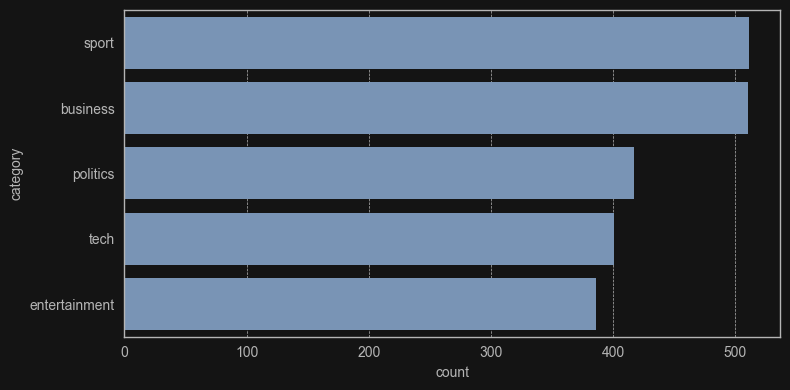

In [8]:
sorted_categories = df['category'].value_counts().index

fig, axes = plt.subplots(figsize=(8, 4))

min_label = df['category'].value_counts().min()
max_label = df['category'].value_counts().max()

print(
    f"min: {min_label}",
    f"max: {max_label}", sep='\n'
)

sb.countplot(df['category'], order=sorted_categories, color=mid_blue, linewidth=0)
plt.tight_layout()

#### Tokenizing headlines
1) apply tokenizing function
2) shuffle dataset before train/test split

In [9]:
from collections import Counter

tokenized_texts = [text.split() for text in df['text']]
word_counts = Counter([word for text in tokenized_texts
                            for word in text])
word_counts.most_common(10)

[('said', 7255),
 ('year', 3319),
 ('mr', 3005),
 ('would', 2581),
 ('also', 2156),
 ('peopl', 2046),
 ('new', 1978),
 ('us', 1972),
 ('one', 1942),
 ('time', 1667)]

In [10]:
word_to_idx = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}
word_to_idx['<PAD>'] = 0
idx_to_word = {i: word for word, i in word_to_idx.items()}

for i in range(10):
    print(idx_to_word[i])

<PAD>
said
year
mr
would
also
peopl
new
us
one


In [11]:
max_length = df['length'].max()

def vectorize_headline(headline):
    result = [word_to_idx[w] for w in headline.split()[:max_length]]
    result = np.pad(result, (0, max_length - len(result)))
    return result

In [12]:
df['text'] = df['text'].apply(vectorize_headline)
df.head()

,category,text,length
0,business,"[49, 69, 483, 10, 2718, 273, 284, 273, 8, 285,...",247
1,business,"[338, 763, 3242, 784, 338, 143, 1139, 269, 369...",229
2,business,"[548, 142, 1761, 124, 1210, 97, 1091, 6754, 64...",159
3,business,"[88, 1107, 120, 143, 3588, 273, 113, 2719, 121...",245
4,business,"[4984, 1140, 253, 1141, 6756, 89, 27, 1113, 12...",166


In [13]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,category,text,length
0,business,"[27, 233, 120, 2055, 514, 27, 233, 120, 2055, ...",217
1,business,"[1282, 45, 592, 1140, 131, 161, 511, 657, 1282...",224
2,sport,"[4014, 678, 237, 2972, 41, 612, 5641, 4014, 49...",230
3,business,"[2474, 89, 1913, 253, 89, 27, 112, 90, 2474, 1...",162
4,politics,"[174, 2062, 65, 372, 57, 405, 93, 1259, 76, 6,...",305


#### Labeling categories

In [14]:
category_to_label = {
    cat: i for i, cat in enumerate(sorted_categories)
}

category_to_label

{'sport': 0, 'business': 1, 'politics': 2, 'tech': 3, 'entertainment': 4}

In [15]:
df['category'] = df['category'].apply(lambda cat: category_to_label[cat])
df.head()

,category,text,length
0,1,"[27, 233, 120, 2055, 514, 27, 233, 120, 2055, ...",217
1,1,"[1282, 45, 592, 1140, 131, 161, 511, 657, 1282...",224
2,0,"[4014, 678, 237, 2972, 41, 612, 5641, 4014, 49...",230
3,1,"[2474, 89, 1913, 253, 89, 27, 112, 90, 2474, 1...",162
4,2,"[174, 2062, 65, 372, 57, 405, 93, 1259, 76, 6,...",305


#### Data Loaders
First converting to numpy

In [16]:
sequences = df['text'].to_numpy()
labels = df['category'].to_numpy()

Checking if each sequence is paired with label correctly

In [17]:
mismatches = df[df['text'] != sequences]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])
    
mismatches = df[df['category'] != labels]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])

Train / Test split

In [18]:
train_size = int(len(df) * 0.7)

train_split = sequences[:train_size], labels[:train_size]
test_split = sequences[train_size:], labels[train_size:]

Length check

In [19]:
len(test_split[0]) + len(train_split[0]) == len(df)

True

x - sequence <br>
y - label <br>
z - length, this will be used later in _pack_padded_sequence_ to separate the sequence from padding tokens<br> 

In [20]:
from torch.utils.data import TensorDataset, DataLoader

def return_loader(dataset, batch_size=8):

    sequences, labels = dataset
        
    x, y, z = [], [], []
    
    for sequence, label in zip(sequences, labels):
        x.append(sequence)
        y.append(label)
        z.append(np.count_nonzero(sequence))
        
    tensor_dataset = TensorDataset(torch.tensor(x).long(),
                                   torch.tensor(z).long(),
                                   torch.tensor(y).long())
    
    return DataLoader(tensor_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [183]:
train_loader  = return_loader(dataset=train_split, batch_size=32)
test_loader = return_loader(dataset=test_split, batch_size=32)

Checks if there are 0 length sequences (empty sequences). <br>
I processed sequences before and there's a small chance that sequence was built mainly from stopwords or other 'irrelevant' words. <br>
That actually lead me before to an Error where the Model received empty sequence with length 0.

In [185]:
for batch in train_loader:
    inputs, lengths, targets = batch
    
    for i in range(32):
        if 0 in lengths[i]:
            print(inputs[i], targets[i], lengths[i])

# The Model
I've used RNN with **LSTM** architecture. <br>
_Dropout_ is applied to the last hidden state _(hidden[-1])_ right before the final linear layer, <br>
but not to the output predictions themselves. <br>
For the forward function we pass the _**X**_ and it's _**lengths**_ that I discussed before.

In [186]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['category']),
    y=df['category']
)

class_weights

array([0.87084149, 0.87254902, 1.06714628, 1.10972569, 1.15284974])

In [187]:
from torch import nn
import torch.nn.utils.rnn as rnn_utils

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, n_layers=1, dropout_rate=0.2):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, lengths):
        x = self.embedding(x)

        x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    
        rnn_out, (hidden, cell) = self.rnn(x)    
    
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        
        return output

Training function

In [189]:
from torch import optim
import copy

def train_model(model, data_loader, class_weights, n_epochs=1, learning_rate=0.001, decay=0.01):
    
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        
    model.to(device)
    class_weights = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    
    loss_history = []
    acc_history = []
    best_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict()) # init weights
    best_epoch = 0
    
    for epoch in range(n_epochs):
        
        model.train()
        total_loss = 0
        
        correct = 0
        total_samples = 0
        
        for i, batch in enumerate(data_loader):
            inputs, lengths, targets = batch
            inputs, targets = (inputs.to(device).long(), targets.to(device).long()) # convert to torch.int64
            lengths = lengths.cpu() # move lengths to cpu
            
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            
            # accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(data_loader)
        avg_accuracy = correct / total_samples
        loss_history.append(avg_loss)
        acc_history.append(avg_accuracy)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
        
        print(
            f"Epoch: {epoch+1:0>2} / {n_epochs}  |  Loss: {avg_loss:.4f}  |  Accuracy: {avg_accuracy:.4f}"
        )
        
    model.load_state_dict(best_weights) # apply best weights
    
    return loss_history, acc_history, best_weights, best_epoch

In [190]:
def test_model(model, data_loader):

    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, lengths, targets in data_loader:
            inputs, targets = inputs.to(device).long(), targets.to(device).long()
            lengths = lengths.cpu()
            
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Training
Setting up model

In [192]:
rnn_model = RNN(vocab_size=len(word_to_idx),
                embed_size=512,
                hidden_size=512,
                dropout_rate=0.3,
                n_layers=1,
                output_size=5)

In [193]:
train_history = train_model(
    model=rnn_model,
    class_weights=class_weights,
    data_loader=train_loader,
    n_epochs=20,
    learning_rate=0.0001, # <<<
    decay=0
)

Epoch: 01 / 20  |  Loss: 1.5947  |  Accuracy: 0.2617
Epoch: 02 / 20  |  Loss: 1.5198  |  Accuracy: 0.4987
Epoch: 03 / 20  |  Loss: 1.4448  |  Accuracy: 0.6348
Epoch: 04 / 20  |  Loss: 1.3487  |  Accuracy: 0.7240
Epoch: 05 / 20  |  Loss: 1.1659  |  Accuracy: 0.7917
Epoch: 06 / 20  |  Loss: 0.6919  |  Accuracy: 0.8275
Epoch: 07 / 20  |  Loss: 0.5929  |  Accuracy: 0.8223
Epoch: 08 / 20  |  Loss: 0.4163  |  Accuracy: 0.8750
Epoch: 09 / 20  |  Loss: 0.2793  |  Accuracy: 0.9258
Epoch: 10 / 20  |  Loss: 0.1994  |  Accuracy: 0.9512
Epoch: 11 / 20  |  Loss: 0.1261  |  Accuracy: 0.9714
Epoch: 12 / 20  |  Loss: 0.1545  |  Accuracy: 0.9590
Epoch: 13 / 20  |  Loss: 0.1509  |  Accuracy: 0.9577
Epoch: 14 / 20  |  Loss: 0.1048  |  Accuracy: 0.9792
Epoch: 15 / 20  |  Loss: 0.0631  |  Accuracy: 0.9844
Epoch: 16 / 20  |  Loss: 0.0763  |  Accuracy: 0.9863
Epoch: 17 / 20  |  Loss: 0.0509  |  Accuracy: 0.9876
Epoch: 18 / 20  |  Loss: 0.0316  |  Accuracy: 0.9922
Epoch: 19 / 20  |  Loss: 0.0256  |  Accuracy: 

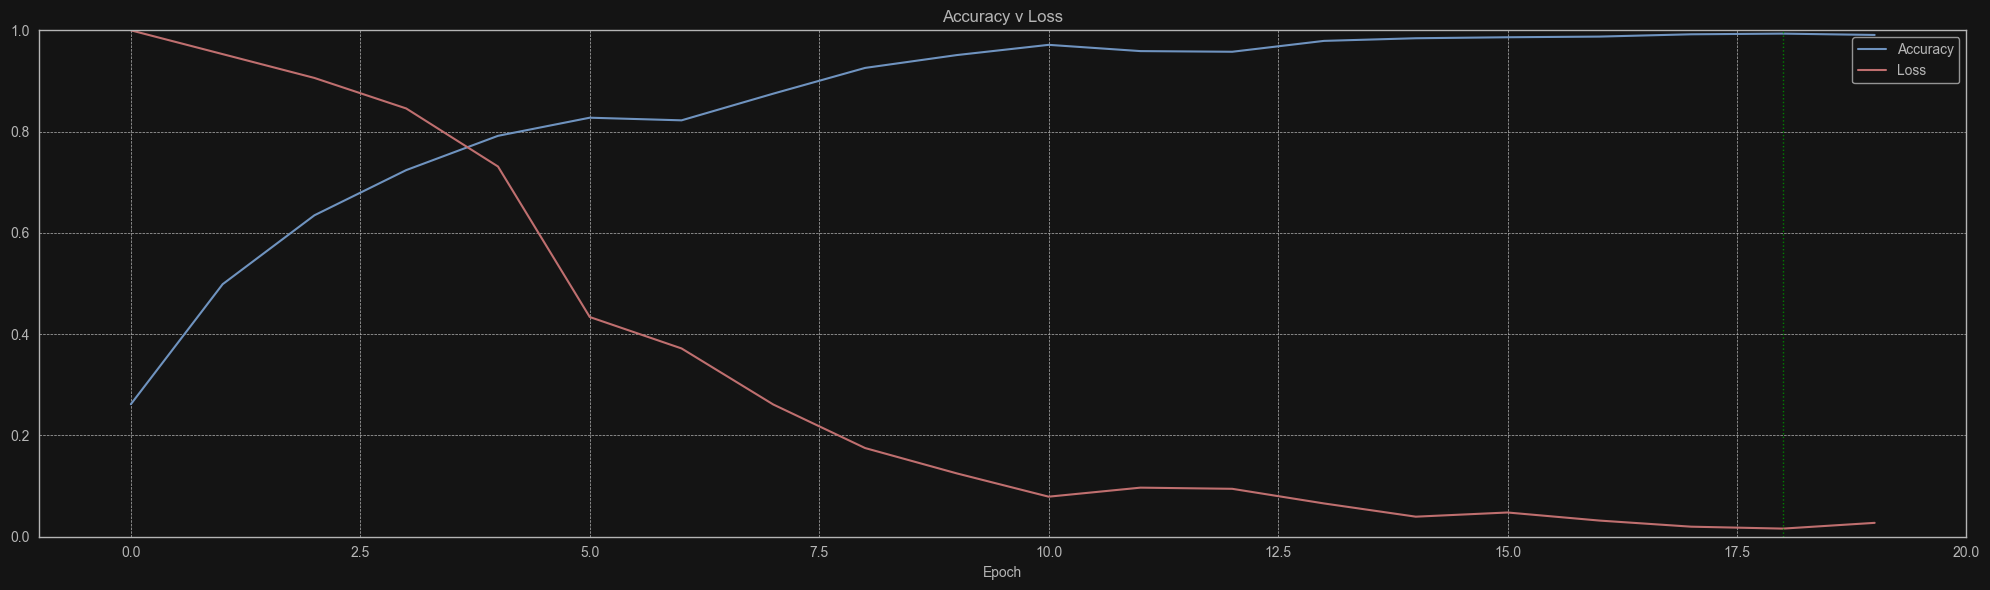

In [194]:
loss_history, acc_history, best_weights, best_epoch = train_history
scaled_loss = [l/max(loss_history) for l in loss_history]
scaled_acc = [a/max(acc_history) for a in acc_history]

fig, axes = plt.subplots(figsize=(20, 6))

sb.lineplot(acc_history, label='Accuracy', color=mid_blue)
sb.lineplot(scaled_loss, label='Loss', color=mid_red)
axes.axvline(x=best_epoch-1, ls=':', lw=1, color='green', label='Best Weights')

plt.xlim((-1, 20))
plt.ylim((0, 1))
plt.title('Accuracy v Loss')
plt.xlabel('Epoch')
plt.tight_layout()

# Testing

In [195]:
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = test_model(model=rnn_model, data_loader=test_loader)
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=category_to_label))

               precision    recall  f1-score   support

        sport       0.96      0.98      0.97       139
     business       0.91      0.94      0.92       124
     politics       0.90      0.90      0.90       135
         tech       0.88      0.93      0.90       127
entertainment       0.95      0.84      0.89       115

     accuracy                           0.92       640
    macro avg       0.92      0.92      0.92       640
 weighted avg       0.92      0.92      0.92       640



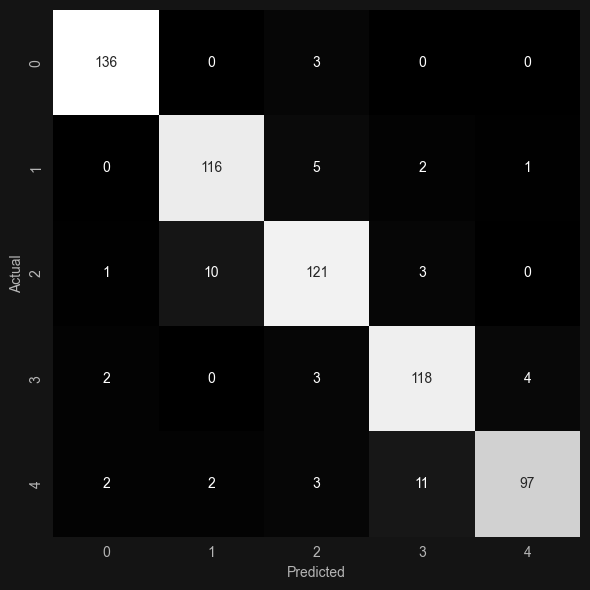

In [196]:
fig = plt.figure(figsize=(6, 6))
sb.heatmap(cm, cbar=False, cmap='Greys_r', annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()

In [197]:
torch.save(rnn_model, '../models/rnn_model_v0.3.pt')